In [1]:
# importing the necessary packages
import torch

import matplotlib.pyplot as plt

from torch import nn
import math
import torch.nn.functional as F
from typing import Tuple
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST
from google.colab import drive

In [2]:
drive.mount('/content/drive')
folder_path = None  # replace with the directory where you will load the saved weights from and store them in.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class VarianceScheduler:
    """
    This class is used to keep track of statistical variables used in the diffusion model
    and also adding noise to the data
    """
    def __init__(self, beta_start: float=0.0001, beta_end: float=0.02, num_steps: int=1000):
        self.betas = torch.linspace(beta_start, beta_end, num_steps) # defining the beta variables
        self.alphas = 1.0 - self.betas # defining the alpha variables
        self.alpha_bars = torch.cumprod(self.alphas, axis=0) # defining the alpha bar variables
        self.num_steps = num_steps

        # NOTE:Feel free to add to this or modify it as you wish


    def add_noise(self, x: torch.Tensor, timestep: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        This method receives the input data and the timestep, generates a noise according to the
        timestep, perturbs the data with the noise, and returns the noisy version of the data and
        the noise itself

        Args:
            x (torch.Tensor): input image [B, 1, 28, 28]
            timestep (torch.Tensor): timesteps [B]

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: noisy_x [B, 1, 28, 28], noise [B, 1, 28, 28]
        """
        device="cpu"
        noise = torch.randn_like(x)
        sqrt_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(self.alpha_bars), timestep, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alpha_bars), timestep, x.shape)
        return sqrt_alphas_cumprod_t.to(device) * x.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

    def get_index_from_list(self, vals, timestep, x_shape):
        if timestep.dim() == 0:
            timestep = timestep.unsqueeze(0)
        batch_size = timestep.shape[0]
        out = vals.gather(-1, timestep.cpu()).reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(timestep.device)
        return out

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, class_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.class_mlp = nn.Linear(class_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, c):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        class_emb = self.relu(self.class_mlp(c))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        class_emb = class_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb + class_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class NoiseEstimatingNet(nn.Module):
    """
    The implementation of the noise estimating network for the diffusion model
    """
    # feel free to add as many arguments as you need or change the arguments
    def __init__(self, time_emb_dim: int, class_emb_dim: int, num_classes: int=10):
        super().__init__()
        # add your codes here
        self.out_dim = 1
        self.time_emb_dim = time_emb_dim
        self.class_emb_dim = class_emb_dim
        self.num_classes = num_classes
        self.image_size = 28
        self.image_channels = 1

        self.down_channels = (
            self.image_size,
            self.image_size * 2,
            self.image_size * 4,
            self.image_size * 8,
            self.image_size * 16
        )
        self.up_channels = (
            self.image_size * 16,
            self.image_size * 8,
            self.image_size * 4,
            self.image_size * 2,
            self.image_size
        )

        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(self.time_emb_dim),
            nn.Linear(self.time_emb_dim, self.time_emb_dim),
            nn.ReLU()
        )
        self.class_embedding = nn.Embedding(self.num_classes, self.class_emb_dim)

        self.conv0 = nn.Conv2d(self.image_channels, self.down_channels[0], kernel_size = 3, padding = 1)
        self.downs = nn.ModuleList([Block(self.down_channels[i], self.down_channels[i + 1], self.time_emb_dim, self.class_emb_dim) for i in range(len(self.down_channels) - 1)])
        self.ups = nn.ModuleList([Block(self.up_channels[i], self.up_channels[i + 1], self.time_emb_dim, self.class_emb_dim, up=True) for i in range(len(self.up_channels) - 1)])
        self.output = nn.Conv2d(self.up_channels[-1], self.image_channels, self.out_dim)

    def forward(self, x: torch.Tensor, timestep: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Estimate the noise given the input noisy image, timestep, and the label

        Args:
            x (torch.Tensor): the input (noisy) image [B, 1, 28, 28]
            timestep (torch.Tensor): timestep [B]
            y (torch.Tensor): the corresponding labels for the images [B]

        Returns:
            torch.Tensor: out (the estimated noise) [B, 1, 28, 28]
        """
        time_embeds = self.time_embedding(timestep)
        class_embeds = self.class_embedding(y)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, time_embeds, class_embeds)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            if x.shape != residual_x.shape:
              x = F.pad(x, (0, 1, 0, 1))
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, time_embeds, class_embeds)
        out = self.output(x) # get the output of the network
        return out

class DiffusionModel(nn.Module):
    """
    The whole diffusion model put together
    """
    def __init__(self, network: nn.Module, var_scheduler: VarianceScheduler):
        """

        Args:
            network (nn.Module): your noise estimating network
            var_scheduler (VarianceScheduler): variance scheduler for getting
                                the statistical variables and the noisy images
        """
        super().__init__()
        self.network = network
        self.var_scheduler = var_scheduler

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.float32:
        """
        The forward method for the diffusion model gets the input images and
        their corresponding labels

        Args:
            x (torch.Tensor): the input image [B, 1, 28, 28]
            y (torch.Tensor): labels [B]

        Returns:
            torch.float32: the loss between the actual noises and the estimated noise
        """
        # step1: sample timesteps
        # step2: compute the noisy versions of the input image according to your timesteps
        # step3: estimate the noises using your noise estimating network
        # step4: compute the loss between the estimated noises and the true noises
        timestep = torch.randint(0, self.var_scheduler.num_steps, (x.shape[0],), device=x.device).long()
        noisy_x, noise = self.var_scheduler.add_noise(x, timestep)
        noisy_x = noisy_x.to(timestep.device)
        noise = noise.to(timestep.device)
        predicted_noise = self.network(noisy_x, timestep, y)
        loss = F.l1_loss(noise, predicted_noise)
        return loss

    @torch.no_grad()
    def generate_sample(self, num_images: int, y, device) -> torch.Tensor:
        """
        This method generates as many samples as specified according to the given labels

        Args:
            num_images (int): number of images to generate
            y (_type_): the corresponding expected labels of each image
            device (_type_): computation device (e.g. torch.device('cuda'))

        Returns:
            torch.Tensor: the generated images [num_images, 1, 28, 28]
        """
        # add your code here
        self.eval()
        samples = torch.randn(num_images, self.network.image_channels, self.network.image_size, self.network.image_size).to(device)
        for idx, t in enumerate(list(range(self.var_scheduler.num_steps))[::-1]):
            time_tensor = (torch.ones(num_images) * t).to(device).long()
            predicted_noise = self.network(samples, time_tensor, y)
            alpha_t = self.var_scheduler.alphas[t]
            alpha_t_bar = self.var_scheduler.alpha_bars[t]
            samples = (1 / alpha_t.sqrt()) * (samples - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * predicted_noise)
            if t > 0:
                z = torch.randn(num_images, self.network.image_channels, self.network.image_size, self.network.image_size).to(device)
                beta_t = self.var_scheduler.betas[t]
                sigma_t = beta_t.sqrt()
                samples = samples + sigma_t * z
        return samples

def load_diffusion_and_generate():
    device = torch.device('cuda')
    var_scheduler = VarianceScheduler(num_steps = 1000) # define your variance scheduler
    network = NoiseEstimatingNet(time_emb_dim = 32, class_emb_dim = 16, num_classes = 10) # define your noise estimating network
    diffusion = DiffusionModel(network=network, var_scheduler=var_scheduler) # define your diffusion model

    # loading the weights of VAE
    diffusion.load_state_dict(torch.load('diffusion.pt'))
    diffusion = diffusion.to(device)

    desired_labels = []
    for i in range(10):
        for _ in range(5):
            desired_labels.append(i)

    desired_labels = torch.tensor(desired_labels).to(device)
    generated_samples = diffusion.generate_sample(50, desired_labels, device)

    return generated_samples

In [4]:
# loading dataset
kwargs = {'root':'datasets/FashionMNIST',
          'train':True,
          'transform':transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 2 * x - 1.)]),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

48000 12000
(28, 28, 1)


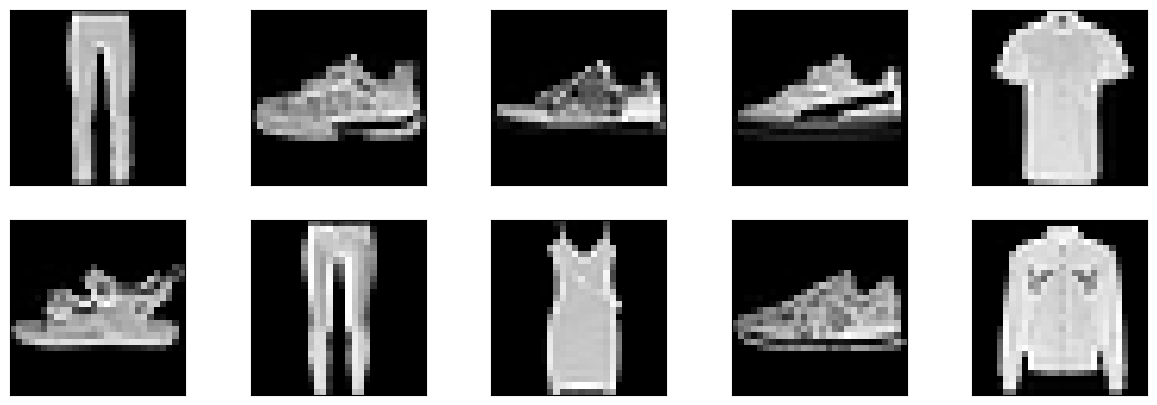

In [5]:
# showing the dataset
print(len(train_dataset), len(val_dataset))

sample_images = [train_dataset[i][0].permute(1, 2, 0).numpy() for i in range(10)]
print(sample_images[0].shape)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(15, 5)
for i in range(2):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(sample_images[i * 5 + j], cmap='gray')
plt.show()

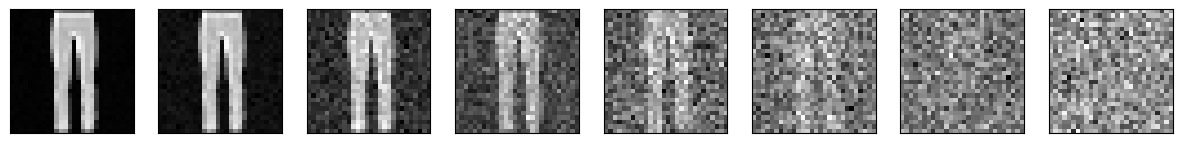

In [6]:
# testing the variance scheduler

var_schd = VarianceScheduler(num_steps=1000)

sample_image = train_dataset[0][0].unsqueeze(0)

noise_levels = [0, 10, 50, 100, 200, 300, 600, 999]

fig, ax = plt.subplots(1, 8)
fig.set_size_inches(15, 10)
for i in range(8):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(var_schd.add_noise(sample_image, torch.tensor(noise_levels[i]))[0].squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
plt.show()

In [7]:
def train(diffusion_model: DiffusionModel,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          device=torch.device('cuda'),
          display_interval: int=5):


  itrs = tqdm(range(epochs))
  itrs.set_description('Train Loss: ? - Val Loss: ?')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      label = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      loss = diffusion_model(x, label)

      loss.backward()
      optimizer.step()

      avg_train_loss += loss.item()

    avg_train_loss /= len(train_loader)

    # validating and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        label = sample[1].type(torch.long).to(device)

        loss = diffusion_model(x, label)

        avg_val_loss += loss.item()

      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}')

    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(diffusion_model.state_dict(), folder_path + 'diffusion.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = diffusion_model.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Train Loss: 0.161 - Val Loss: 0.120:   0%|          | 0/20 [00:46<?, ?it/s]

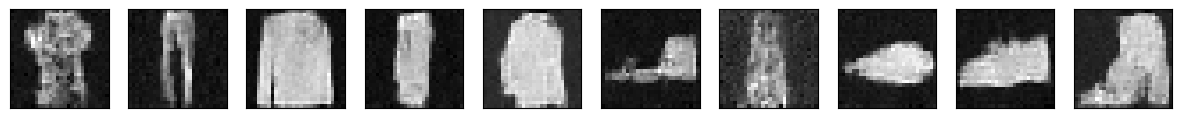

Train Loss: 0.094 - Val Loss: 0.091:  25%|██▌       | 5/20 [04:36<11:20, 45.34s/it]

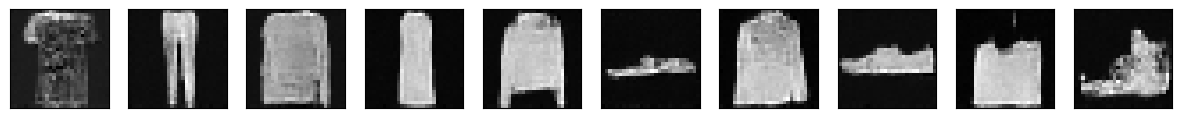

Train Loss: 0.090 - Val Loss: 0.090:  50%|█████     | 10/20 [08:25<07:32, 45.22s/it]

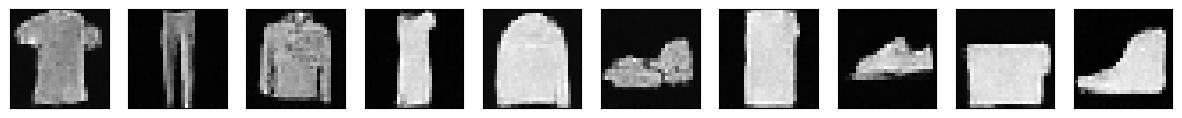

Train Loss: 0.090 - Val Loss: 0.096:  75%|███████▌  | 15/20 [12:14<03:45, 45.06s/it]

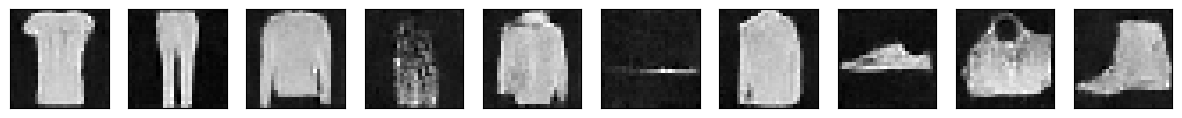

Train Loss: 0.086 - Val Loss: 0.091:  95%|█████████▌| 19/20 [15:16<00:44, 44.88s/it]

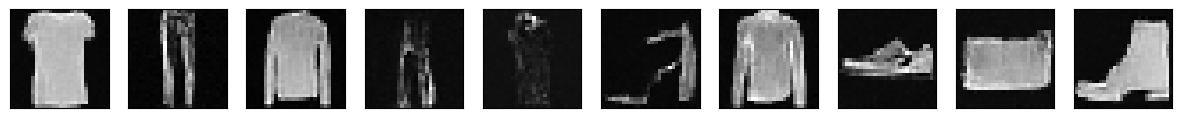

Train Loss: 0.086 - Val Loss: 0.091: 100%|██████████| 20/20 [15:23<00:00, 46.17s/it]


In [8]:
# training the diffusion model

# setting the configurations
device = torch.device('cuda')
num_steps = 1000 # define the number of steps (>500)
batch_size = 64 # define your batch size
lr = 0.001 # specify yout
epochs = 20 # feel free to change the epochs as needed
num_classes = 10
display_interval = 5 # feel free to change; set to None if you do not want to see generated images during the training

# defining the diffusion model component nets
var_scheduler = VarianceScheduler(num_steps = num_steps) # define your variance scheduler
noise_net = NoiseEstimatingNet(time_emb_dim = 32, class_emb_dim = 32, num_classes = 10) #define your noise estimating network

# loading a train and validation data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# defining the diffusion model
diffusion = DiffusionModel(noise_net, var_scheduler).to(device)

optimizer = optim.Adam(diffusion.parameters(), lr) # specify your optimizer; e.g. optim.Adam(diffusion.parameters(), lr)

# training the diffusion model
train(diffusion_model=diffusion,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      device=device,
      display_interval=display_interval)

In [9]:
# a classifier trained on FashionMNIST (DO NOT CHANGE THE CODE BELOW)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

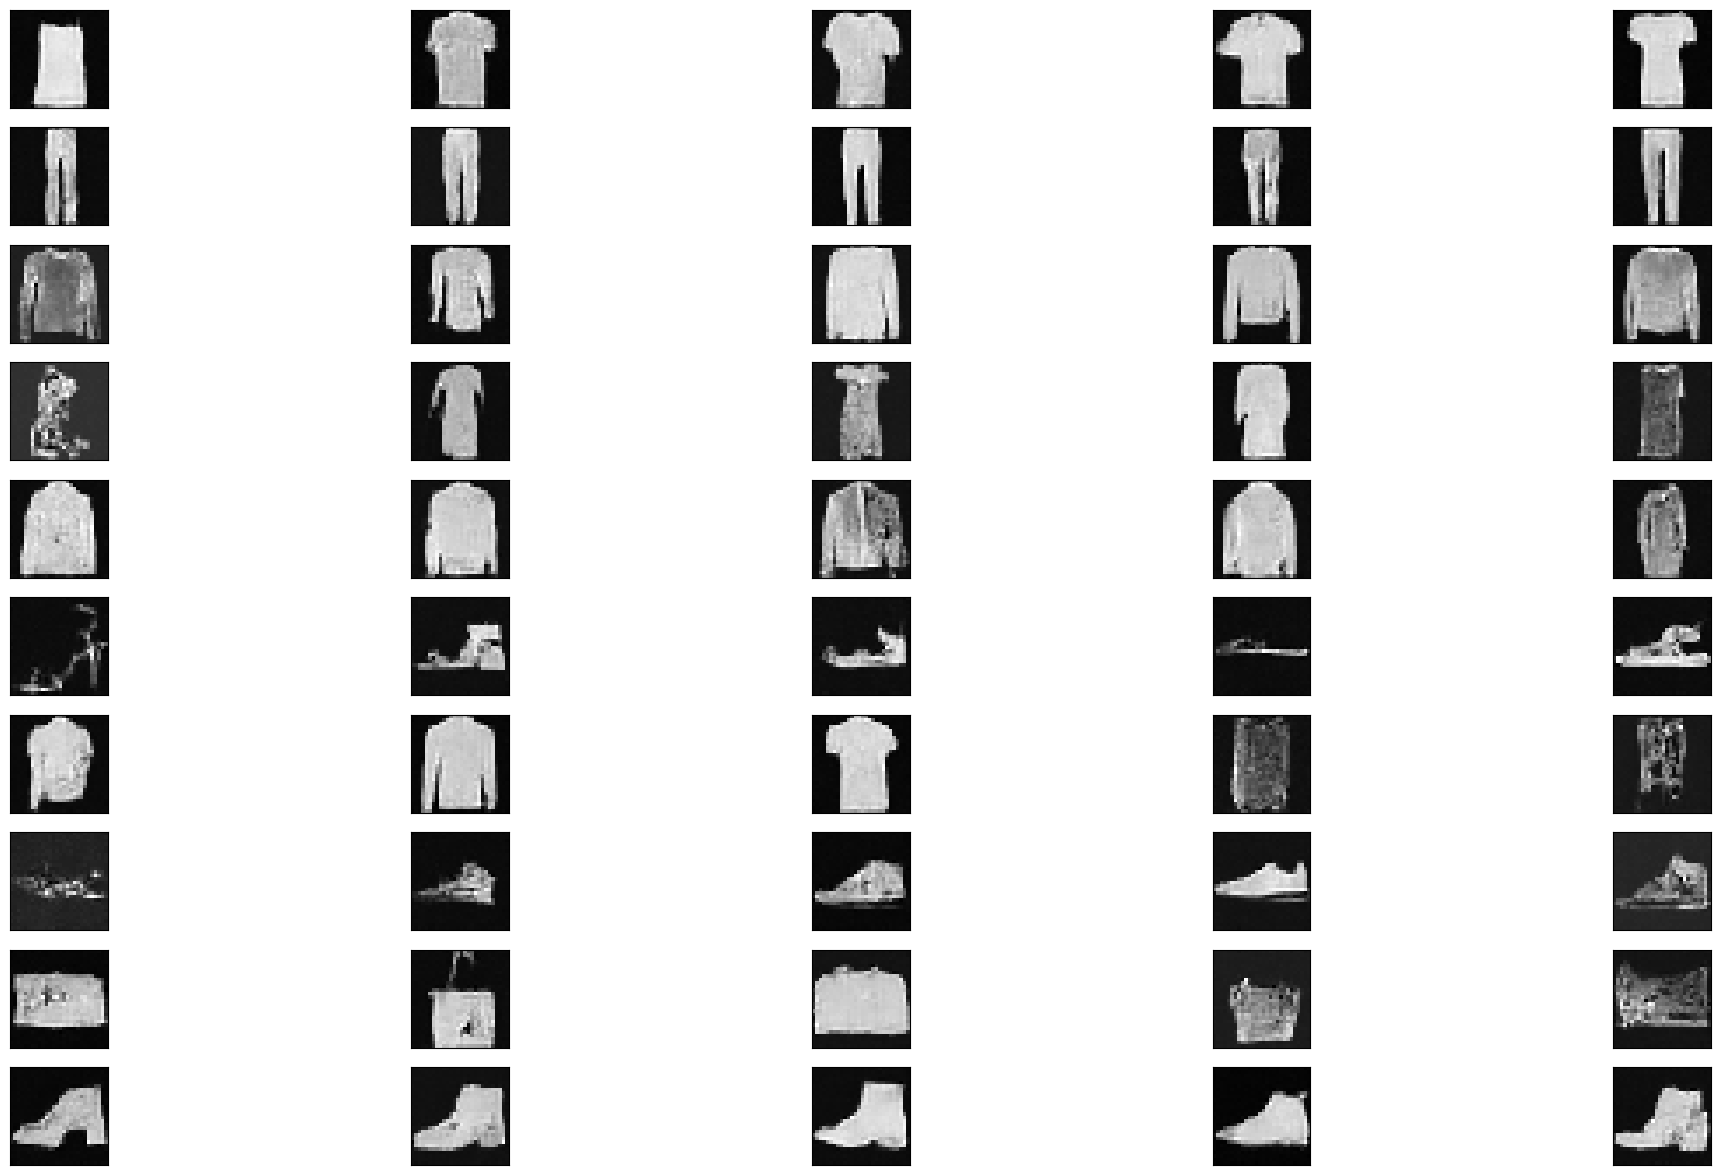

tensor([6, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 4, 2, 2, 2, 0, 3, 3, 3, 3, 4, 6, 4, 4,
        3, 5, 5, 5, 5, 5, 4, 4, 0, 6, 6, 5, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
82.00


In [10]:
# here we use the classifier to see if how well it can classify the generated images (do not change the following code)
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).to(device)

# load your diffusion model

diffusion.load_state_dict(torch.load(folder_path + 'diffusion.pt'))
diffusion = diffusion.to(device)

# generate samples from the Diffusion
generated_samples = diffusion.generate_sample(50, desired_labels, device)

# normalizing the results
min_per_batch = generated_samples.flatten(start_dim=1).min(dim=-1).values.reshape(-1, 1, 1, 1)
max_per_batch = generated_samples.flatten(start_dim=1).max(dim=-1).values.reshape(-1, 1, 1, 1)

generated_samples = (generated_samples - min_per_batch) / (max_per_batch - min_per_batch)

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load(folder_path + 'classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')